In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random

In [86]:
lowerLimit = 0.975
upperLimit = 0.99



class Node():    
    def __init__(self, label:int, edge_labels: list):
        self.label = label
        self.edges = edge_labels
        self.spins = None
        if len(self.edges) == 1:
            self.isLeaf = True
        else:
            self.isLeaf = False
        
        self.magnetizations = {e:None for e in self.edges}

    def generate_spins(self, numSignals:int, tree):
        self.spins = 2*np.random.binomial(1,1/2, numSignals)-1
        for e in self.edges:
            e = tree.edges[e]
            neighbors = [node for node in e.vertices if node!=self.label]
            neighbor = neighbors[0]
            neighbor = tree.vertices[neighbor]
            p = (1-e.true_parameter)/2
            flip = 1-2*np.random.binomial(1, p, numSignals)
            give_spin = flip*self.spins
            neighbor.give_spin_and_propagate(give_spin, e.label, tree)

    def give_spin_and_propagate(self, spins, edge, tree):
        self.spins = spins        
        if not self.isLeaf:
            for e in self.edges:
                if e!=edge:    
                    e = tree.edges[e]
                    neighbor = e.other_neighbor(self.label)
                    neighbor = tree.vertices[neighbor]
                    p = (1-e.true_parameter)/2
                    flip = 1-2*np.random.binomial(1, p, spins.shape)
                    give_spin = flip*self.spins
                    neighbor.give_spin_and_propagate(give_spin, e.label, tree)

    def magnetize(self, away_from_edge, tree):
        if self.isLeaf:
            self.magnetizations[away_from_edge] = self.spins
        else:
            other_edges = [e for e in self.edges if e!=away_from_edge]
            e1,e2 = other_edges[0], other_edges[1]
            e1,e2 = tree.edges[e1], tree.edges[e2]
            v1, v2 = e1.other_neighbor(self.label), e2.other_neighbor(self.label)
            v1, v2 = tree.vertices[v1], tree.vertices[v2]
            theta1,theta2 = e1.estimated_parameter, e2.estimated_parameter

            q = np.vectorize(lambda x,y: (x+y)/(1+x*y))
           
            if v1.magnetizations[e1.label] is None:
                v1.magnetize(e1.label, tree)
            if v2.magnetizations[e2.label] is None:
                v2.magnetize(e2.label, tree)
            
            Z1, Z2 = v1.magnetizations[e1.label], v2.magnetizations[e2.label]

            self.magnetizations[away_from_edge] = q(theta1*Z1,theta2*Z2)    


    def update_magnetization(self, included_edge, tree):
        if not self.isLeaf:
            other_edges = [e for e in self.edges if e!=included_edge]

            ## Get other edges

            e1, e2 = other_edges[0], other_edges[1]
            e1, e2 = tree.edges[e1], tree.edges[e2]
            
            
            ## Get updated magnetization
            e0 = tree.edges[included_edge]
            u = e0.other_neighbor(self.label)
            u = tree.vertices[u]
            theta_u = e0.estimated_parameter
            Z_u = u.magnetizations[included_edge]

            ## Get magnetization from other neighbors
            v1, v2 = e1.other_neighbor(self.label), e2.other_neighbor(self.label)
            v1, v2 = tree.vertices[v1], tree.vertices[v2]

            theta1,theta2 = e1.estimated_parameter, e2.estimated_parameter
            if v1.magnetizations[e1.label] is None:
                v1.magnetize(e1.label, tree)
            if v2.magnetizations[e2.label] is None:
                v2.magnetize(e2.label, tree)
            Z1, Z2 = v1.magnetizations[e1.label], v2.magnetizations[e2.label]

            q = np.vectorize(lambda x,y: (x+y)/(1+x*y))

            ## Update magnetization for self

            self.magnetizations[e1.label] = q(theta2*Z2, theta_u*Z_u)
            self.magnetizations[e2.label] = q(theta1*Z1, theta_u*Z_u)

            ## Propogate

            v1.update_magnetization(e1.label, tree)
            v2.update_magnetization(e2.label, tree)





class Edge():
    def __init__(self, label, vertices: list[tuple]):
        self.label = label
        self.vertices = vertices
        self.true_parameter = np.float128(np.random.uniform(lowerLimit, upperLimit))
        self.estimated_parameter = np.float128(np.random.uniform(lowerLimit, upperLimit))
        self.estimated_parameter

    def other_neighbor(self, nei):
        if nei not in self.vertices:
            raise Exception('Vertex not found.')
        else:
            v = [n for n in self.vertices if n!= nei]
            return v[0]

    def update_parameter(self, Zu,Zv):
        prod = Zu*Zv
        if all(prod>=0):
            self.estimated_parameter = upperLimit
        elif all(prod<=0):
            self.estimated_parameter = -upperLimit
        else:

            f = lambda t: np.mean(prod/(1+t*prod),dtype= np.float128)
            a = scipy.optimize.bisect(f,-1,1, maxiter = 100)
            self.estimated_parameter = np.float128(a)

class Tree():
    def __init__(self, vertices:dict, edges:dict,root:int, n_samples:int):
        if root not in vertices:
            raise Exception("Root is not a vertex.")
        
        self.edges = dict()
        for e,inc_vert in edges.items():
            self.edges[e] = Edge(e, inc_vert)
            for v in inc_vert:
                if v not in vertices:
                    raise Exception("Incident vertices not included in vertex dict.")

        self.vertices = dict()
        for v, inc_edges in vertices.items():
            self.vertices[v] = Node(v,inc_edges)
            for e in inc_edges:
                if e not in edges:
                    raise Exception("Incident edge not included in edge dict.")
                
        self.root = root

        self.root_vertex = self.vertices[root]

        self.generate_spins(n_samples)


    def generate_spins(self, numSamples):
        self.root_vertex.generate_spins(numSamples, self)
    

    def coordinate_update(self, edge_label):
        u, v = self.edges[edge_label].vertices
        u, v = self.vertices[u], self.vertices[v]
        if u.magnetizations[edge_label] is None:
            u.magnetize(edge_label, self)
        if v.magnetizations[edge_label] is None:
            v.magnetize(edge_label, self)
        Zu, Zv = u.magnetizations[edge_label], v.magnetizations[edge_label]
        
        ### Update theta

        self.edges[edge_label].update_parameter(Zu,Zv)

        #### Proogate
        u.update_magnetization(edge_label,self)
        v.update_magnetization(edge_label, self)
            
    def update_round(self, orders = [1]):
        error = [[] for _ in orders]
        for e in self.edges.keys():
            self.coordinate_update(e)
            error_list = self.get_gaps(orders)
            for p,e in enumerate(error_list):
                error[p].append(e)
        return error
    
    def get_gaps(self, orders = [2]):
        true_params = np.array([e.true_parameter for e in self.edges.values()], dtype = np.float128)
        est_params = np.array([e.estimated_parameter for e in self.edges.values()], dtype = np.float128)
        norms = [np.linalg.norm(true_params-est_params,p) for p in orders]
        return norms

    def get_l1_gap(self):
        true_params = np.array([e.true_parameter for e in self.edges.values()], dtype = np.float128)
        est_params = np.array([e.estimated_parameter for e in self.edges.values()], dtype = np.float128)
        return np.linalg.norm(true_params-est_params,1)
    

def kingman_tree(n_leaves, n_samples = 100):
    vertices = {j+1: [] for j in range(n_leaves)}
    leafs = {j+1 for j in range(n_leaves)}
    edges = {}
    root = 0
    next_label = n_leaves+1
    edge_label = 1
    while len(leafs)>=2:
        keys = list(leafs)
        l,r = random.sample(keys,2)
        vertices[next_label] = [edge_label, edge_label+1]
        vertices[l].append(edge_label)
        vertices[r].append(edge_label+1)

        edges[edge_label] = [next_label, l]
        edges[edge_label+1] = [next_label, r]


        leafs.remove(l)
        leafs.remove(r)
        leafs.add(next_label)
        next_label+=1
        edge_label+=2
    r = list(leafs)[0]
    vertices[root] = [edge_label]
    vertices[r].append(edge_label)
    edges[edge_label] = [root, r]
    return Tree(vertices, edges, root, n_samples)


In [88]:
tree = kingman_tree(65,2000)


In [89]:
error = np.array([tree.get_gaps([1,2])]).reshape(-1,1)
epochs = 3
for _ in range(epochs):
    error = np.hstack((error, np.array(tree.update_round([1,2]))))
    



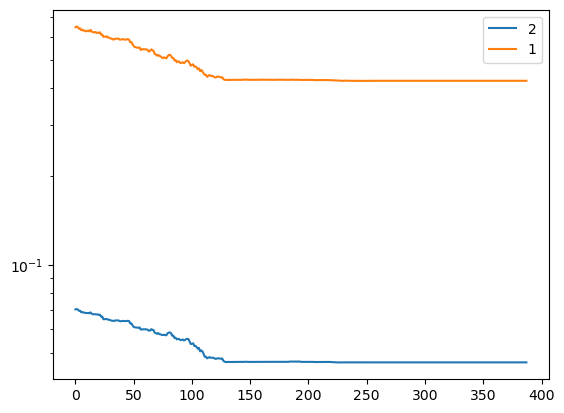

In [90]:
plt.plot([j for j in range(error.shape[-1])], error[1,:], label = '2')
plt.plot([j for j in range(error.shape[-1])], error[0,:], label = '1')
plt.yscale('log')
plt.legend()

In [63]:
np.asanyarray(error)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4, 2) + inhomogeneous part.

In [64]:
for e in error:
    print(len(e))

2
2
2
2


In [65]:
e1 = error[1]

In [41]:
len(error[1][0])

1

In [66]:
e1 = error[1]
np.array(e1).shape

(2, 39)

In [67]:
np.vstack(tuple(map(np.array,error)))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 39

In [68]:
e0 = np.array(error[0])

In [69]:
e0.shape

(2,)